# Step 1: Load the data

In [2]:
import pandas as pd

df = pd.read_csv('steam_games.csv')

# Step 2: Initial data exploration

In [3]:
df.head()

,app_id,name,detailed_description,short_description,genres,categories,price,release_date,developers,publishers
0,730,Counter-Strike 2,"For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...","Action, Free To Play","Multi-player, Cross-Platform Multiplayer, Stea...",0.00,"Aug 21, 2012",Valve,Valve
1,1172470,Apex Legends™,Apex Legends: ProdigyAbout the GameConquer wit...,"Apex Legends is the award-winning, free-to-pla...","Action, Adventure, Free To Play","Multi-player, PvP, Online PvP, Co-op, Online C...",0.00,"Nov 4, 2020",Respawn,Electronic Arts
2,578080,PUBG: BATTLEGROUNDS,LAND Drop into an ever-growing and changing se...,"PUBG: BATTLEGROUNDS, the high-stakes winner-ta...","Action, Adventure, Massively Multiplayer, Free...","Multi-player, PvP, Online PvP, Stats, Remote P...",0.00,"Dec 21, 2017",PUBG Corporation,"KRAFTON, Inc."
3,1623730,Palworld,"Q. What kind of game is this?A. In this game, ...","Fight, farm, build and work alongside mysterio...","Action, Adventure, Indie, RPG, Early Access","Single-player, Multi-player, Co-op, Online Co-...",22.49,"Jan 18, 2024",Pocketpair,Pocketpair
4,440,Team Fortress 2,"""The most fun you can have online"" - PC Gamer ...",Nine distinct classes provide a broad range of...,"Action, Free To Play","Multi-player, Cross-Platform Multiplayer, Stea...",0.00,"Oct 10, 2007",Valve,Valve


In [4]:
missing_info = df.isnull().sum()
for col in df.columns:
    missing_count = missing_info[col]
    missing_pct = (missing_count / len(df)) * 100
    print(f"{col}: {missing_count} missing ({missing_pct:.1f}%)")

app_id: 0 missing (0.0%)
name: 0 missing (0.0%)
detailed_description: 8 missing (0.3%)
short_description: 0 missing (0.0%)
genres: 5 missing (0.2%)
categories: 11 missing (0.4%)
price: 207 missing (7.9%)
release_date: 7 missing (0.3%)
developers: 8 missing (0.3%)
publishers: 23 missing (0.9%)


# Step 3: Analyze text data

In [5]:
df['desc_length'] = df['detailed_description'].fillna('').str.len()
df['short_desc_length'] = df['short_description'].fillna('').str.len()

print(f"Detailed description lengths - Min: {df['desc_length'].min()}, Max: {df['desc_length'].max()}, Mean: {df['desc_length'].mean():.0f}")
print(f"Short description lengths - Min: {df['short_desc_length'].min()}, Max: {df['short_desc_length'].max()}, Mean: {df['short_desc_length'].mean():.0f}")

Detailed description lengths - Min: 0, Max: 2003, Mean: 1431
Short description lengths - Min: 16, Max: 342, Mean: 218


In [6]:
# Check for HTML tags
html_pattern = r'<[^>]*>'
has_html = df['detailed_description'].fillna('').str.contains(html_pattern).sum()
print(f"\nGames with HTML tags: {has_html}")


Games with HTML tags: 0


# Step 4: Text cleaning function

In [8]:
import re

def clean_text(text):
    """Clean text for BERT processing"""
    if pd.isna(text) or text == '':
        return ''

    text = str(text)

    # Remove HTML tags
    text = re.sub(r'<[^>]*>', ' ', text)

    # Remove excessive whitespace and special characters
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s.,!?;:()\-\'"/]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Step 5: Apply data cleaning

In [9]:
# Clean text columns
df['name_clean'] = df['name'].apply(clean_text)
df['detailed_description_clean'] = df['detailed_description'].apply(clean_text)
df['short_description_clean'] = df['short_description'].apply(clean_text)

In [10]:
# Handle missing detailed descriptions - use short description as fallback
mask = (df['detailed_description_clean'] == '') | df['detailed_description_clean'].isna()
df.loc[mask, 'detailed_description_clean'] = df.loc[mask, 'short_description_clean']

In [11]:
# Fill missing categorical data
df['genres'] = df['genres'].fillna('Unknown')
df['categories'] = df['categories'].fillna('Unknown')
df['developers'] = df['developers'].fillna('Unknown')
df['publishers'] = df['publishers'].fillna('Unknown')
df['price'] = df['price'].fillna(0)

# Step 6: Create combined text for BERT

In [13]:
df['combined_text'] = (
    df['name_clean'] + ' ' +
    df['detailed_description_clean'] + ' ' +
    df['genres'].apply(lambda x: x if x != 'Unknown' else '') + ' ' +
    df['categories'].apply(lambda x: x if x != 'Unknown' else '')
)

# Clean the combined text
df['combined_text'] = df['combined_text'].apply(clean_text)

In [14]:
# Filter out games with very short text (less than 50 characters)
original_count = len(df)
df = df[df['combined_text'].str.len() >= 50].copy()
filtered_count = len(df)

print(f"Original games: {original_count}")
print(f"After filtering: {filtered_count}")
print(f"Removed: {original_count - filtered_count} games with insufficient text")

Original games: 2618
After filtering: 2618
Removed: 0 games with insufficient text


# Step 7: Analyze cleaned data

In [17]:
text_lengths = df['combined_text'].str.len()
print(f"Combined text length - Min: {text_lengths.min()}, Max: {text_lengths.max()}, Mean: {text_lengths.mean():.0f}")

# Estimate token counts (roughly 1 token = 4 characters)
token_estimates = text_lengths / 4
print(f"Estimated tokens - Min: {token_estimates.min():.0f}, Max: {token_estimates.max():.0f}, Mean: {token_estimates.mean():.0f}")

# Check how many exceed BERT's 512 token limit
over_limit = (token_estimates > 512).sum()
print(f"Games over 512 tokens: {over_limit} ({(over_limit/len(df)*100):.1f}%)")

Combined text length - Min: 174, Max: 2537, Mean: 1597
Estimated tokens - Min: 44, Max: 634, Mean: 399
Games over 512 tokens: 969 (37.0%)


# Step 8: Show sample cleaned data

In [18]:
for i in range(3):
    game = df.iloc[i]
    print(f"\n{i+1}. {game['name']}")
    print(f"   Text length: {len(game['combined_text'])} chars")
    print(f"   Preview: {game['combined_text'][:200]}...")


1. Counter-Strike 2
   Text length: 1257 chars
   Preview: Counter-Strike 2 For over two decades, Counter-Strike has offered an elite competitive experience, one shaped by millions of players from across the globe. And now the next chapter in the CS story is ...

2. Apex Legends™
   Text length: 1173 chars
   Preview: Apex Legends Apex Legends: ProdigyAbout the GameConquer with character in Apex Legends, a free-to-play Hero shooter where legendary characters with powerful abilities team up to battle for fame fortun...

3. PUBG: BATTLEGROUNDS
   Text length: 1569 chars
   Preview: PUBG: BATTLEGROUNDS LAND Drop into an ever-growing and changing selection of maps to keep you challenged. Will you choose the safer outskirts and risk not getting enough loot or hot drop into the dens...


# Step 9: Genre analysis

In [19]:
genre_counts = {}
for genres_str in df['genres']:
    if genres_str != 'Unknown' and pd.notna(genres_str):
        for genre in genres_str.split(','):
            genre = genre.strip()
            genre_counts[genre] = genre_counts.get(genre, 0) + 1

top_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:10]
for genre, count in top_genres:
    print(f"{genre}: {count}")

Indie: 1413
Action: 1380
Adventure: 1026
RPG: 684
Strategy: 649
Simulation: 611
Casual: 571
Free To Play: 388
Massively Multiplayer: 198
Early Access: 165


# Step 10: Visualize data distribution

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

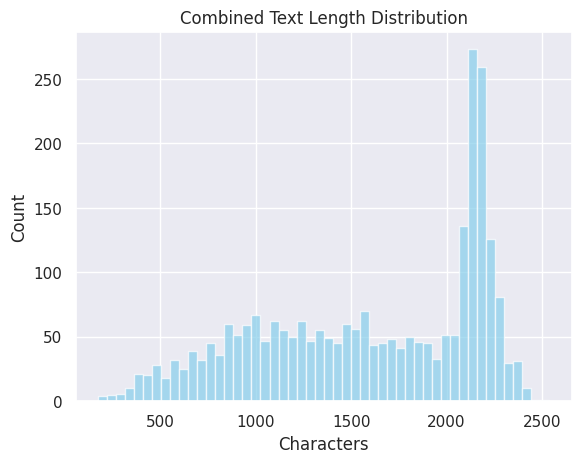

In [30]:
# Text length distribution
plt.hist(text_lengths, bins=50, alpha=0.7, color='skyblue')
plt.title('Combined Text Length Distribution')
plt.xlabel('Characters')
plt.ylabel('Count')

plt.show()

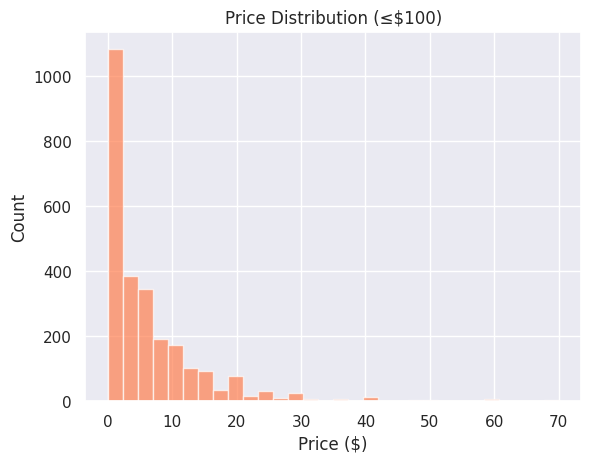

In [32]:
# Price distribution
prices = df[df['price'] <= 100]['price']  # Filter extreme outliers for visualization
plt.hist(prices, bins=30, alpha=0.7, color='coral')
plt.title('Price Distribution (≤$100)')
plt.xlabel('Price ($)')
plt.ylabel('Count')

plt.show()

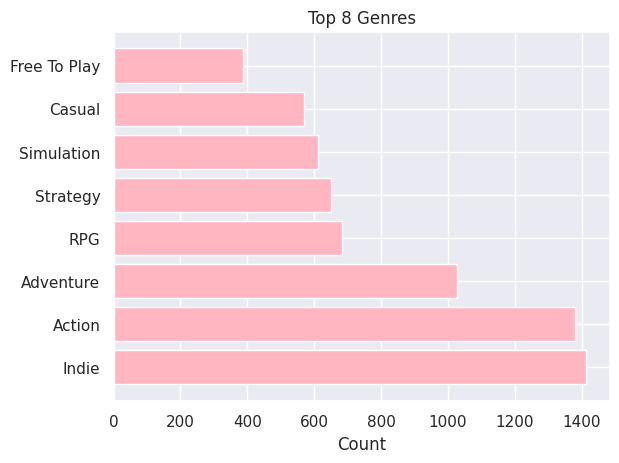

In [33]:
# Top genres
genres, counts = zip(*top_genres[:8])
plt.barh(range(len(genres)), counts, color='lightpink')
plt.yticks(range(len(genres)), genres)
plt.title('Top 8 Genres')
plt.xlabel('Count')

plt.show()

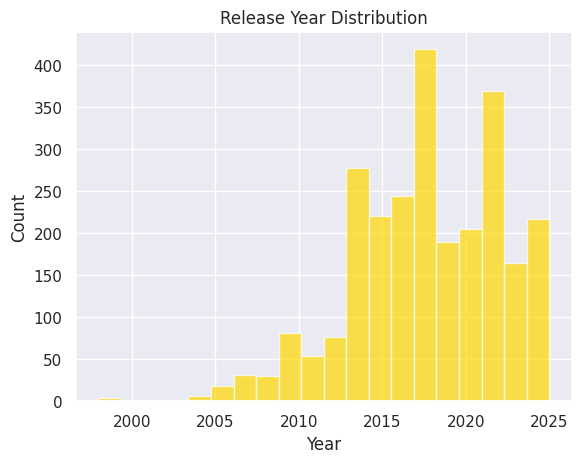

In [36]:
df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year
years = df['release_year'].dropna()
# years = years[years >= 2000]  # Focus on recent games
plt.hist(years, bins=20, alpha=0.7, color='gold')
plt.title('Release Year Distribution')
plt.xlabel('Year')
plt.ylabel('Count')

plt.show()

# Step 11: Prepare final dataset for BERT

In [37]:
# Keep only necessary columns for the recommendation system
final_columns = [
    'app_id', 'name', 'combined_text', 'genres', 'categories',
    'price', 'release_date', 'developers', 'publishers'
]

df_final = df[final_columns].copy()

In [38]:
df_final.head()

,app_id,name,combined_text,genres,categories,price,release_date,developers,publishers
0,730,Counter-Strike 2,"Counter-Strike 2 For over two decades, Counter...","Action, Free To Play","Multi-player, Cross-Platform Multiplayer, Stea...",0.00,"Aug 21, 2012",Valve,Valve
1,1172470,Apex Legends™,Apex Legends Apex Legends: ProdigyAbout the Ga...,"Action, Adventure, Free To Play","Multi-player, PvP, Online PvP, Co-op, Online C...",0.00,"Nov 4, 2020",Respawn,Electronic Arts
2,578080,PUBG: BATTLEGROUNDS,PUBG: BATTLEGROUNDS LAND Drop into an ever-gro...,"Action, Adventure, Massively Multiplayer, Free...","Multi-player, PvP, Online PvP, Stats, Remote P...",0.00,"Dec 21, 2017",PUBG Corporation,"KRAFTON, Inc."
3,1623730,Palworld,Palworld Q. What kind of game is this?A. In th...,"Action, Adventure, Indie, RPG, Early Access","Single-player, Multi-player, Co-op, Online Co-...",22.49,"Jan 18, 2024",Pocketpair,Pocketpair
4,440,Team Fortress 2,"Team Fortress 2 ""The most fun you can have onl...","Action, Free To Play","Multi-player, Cross-Platform Multiplayer, Stea...",0.00,"Oct 10, 2007",Valve,Valve


# BERT Embeddings and KNN Recommendation System

# Step 1: Load cleaned data (assuming you have it from previous step)
# Step 2: Use full sentences (No truncation!)

In [50]:
# Use the full combined text directly
df_final['bert_text'] = df_final['combined_text']

# Step 3: Initialize BERT model

In [44]:
from sentence_transformers import SentenceTransformer

# Using sentence-transformers - optimized for semantic similarity
model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast and effective for recommendations

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Step 4: Generate embeddings in batches

In [51]:
from tqdm import tqdm
import time

def generate_embeddings_batch(texts, model, batch_size=32):
    """Generate BERT embeddings in batches to manage memory"""
    embeddings = []

    print(f"Generating embeddings for {len(texts)} texts...")
    start_time = time.time()

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        batch_embeddings = model.encode(batch, show_progress_bar=False)
        embeddings.extend(batch_embeddings)

        if (i // batch_size + 1) % 20 == 0:  # Progress update every 20 batches
            elapsed = time.time() - start_time
            progress = (i + batch_size) / len(texts) * 100
            print(f"Progress: {progress:.1f}% ({elapsed:.1f}s elapsed)")

    total_time = time.time() - start_time
    print(f"Embeddings generated in {total_time:.1f} seconds")

    return np.array(embeddings)

In [52]:
# Generate embeddings
embeddings = generate_embeddings_batch(df_final['bert_text'].tolist(), model, batch_size=32)

Generating embeddings for 2618 texts...
Progress: 24.4% (80.1s elapsed)
Progress: 48.9% (161.3s elapsed)
Progress: 73.3% (242.2s elapsed)
Progress: 97.8% (318.1s elapsed)
Embeddings generated in 324.4 seconds


# Step 5: Build KNN model

In [54]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

# Using cosine similarity (works well with BERT embeddings)
knn_model = NearestNeighbors(
    n_neighbors=10,  # Find 10 similar games
    metric='cosine',
    algorithm='brute'  # Most accurate for cosine similarity
)

In [55]:
knn_model.fit(embeddings)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

# Step 6: Create recommendation function

In [56]:
def recommend_from_description(description, df, embeddings, knn_model, n_recommendations=5):
    """
    Recommend games based on a text description
    """
    # Use the full description without truncation
    clean_desc = description.strip()

    # Generate embedding for the description
    desc_embedding = model.encode([clean_desc])

    # Find similar games
    distances, indices = knn_model.kneighbors(desc_embedding, n_neighbors=n_recommendations)

    # Convert to similarity scores
    similarity_scores = 1 - distances[0]

    # Get recommended games
    recommendations = df.iloc[indices[0]].copy()
    recommendations['similarity_score'] = similarity_scores

    return recommendations[['name', 'genres', 'price', 'similarity_score']]

# Step 7: Test the recommendation system

In [65]:
# Test 2: Concrete semantic tests focusing on actual gameplay elements
# Short, concrete description focusing on actual gameplay elements
csgo_concrete = "5v5 rounds economy weapons tactical shooter defuse"

csgo_recs = recommend_from_description(
    csgo_concrete,
    df_final, embeddings, knn_model, n_recommendations=7
)

csgo_recs

,name,genres,price,similarity_score
487,Modern Combat 5,"Action, Free To Play, Massively Multiplayer",0.00,0.446479
807,Sniper Fury,"Action, Free To Play",0.00,0.406300
799,Zero Hour,"Action, Simulation, Strategy",9.99,0.395882
661,Sniper Ghost Warrior Contracts 2,Action,3.99,0.395154
1197,Space Beret,"Action, Casual, Indie",0.49,0.380069
292,Call of Duty® 4: Modern Warfare® (2007),Action,9.99,0.365881
631,Gears 5,"Action, Adventure",29.99,0.365342


In [67]:
# Test 3: Besiege concrete test
# Focus on concrete building and destruction elements
besiege_concrete = "build machines physics destruction cannons siege walls"

besiege_recs = recommend_from_description(
    besiege_concrete,
    df_final, embeddings, knn_model, n_recommendations=7
)

besiege_recs

,name,genres,price,similarity_score
1446,Castle Story,"Indie, Simulation, Strategy",2.49,0.482510
353,Creative Destruction,"Action, Adventure, Casual, Massively Multiplayer",0.00,0.467006
1752,Mainframe Defenders: Meltdown - Prologue,"Indie, Strategy, Free To Play",0.00,0.448495
30,War Robots: Frontiers,"Action, Simulation, Free To Play",0.00,0.430741
1194,Crazy Machines 3,"Simulation, Strategy",0.99,0.408357
1170,Guns and Robots,"Action, Indie, Massively Multiplayer, RPG",0.00,0.404895
112,War Robots,"Action, Free To Play",0.00,0.400219


In [68]:
# Test 4: Racing game test
racing_concrete = "cars racing tracks speed championship driving"

racing_recs = recommend_from_description(
    racing_concrete,
    df_final, embeddings, knn_model, n_recommendations=7
)

racing_recs

,name,genres,price,similarity_score
1574,Project CARS 3,Racing,59.99,0.567404
971,TrackMania² Stadium,"Racing, Sports",4.99,0.565210
1024,Motorsport Manager,"Racing, Simulation, Sports, Strategy",2.99,0.561029
1529,Automobilista 2,"Action, Indie, Racing, Simulation, Sports",3.99,0.558729
893,GRID Autosport,"Racing, Sports",0.00,0.536620
1338,HOT WHEELS UNLEASHED™,Racing,5.99,0.533936
1701,Victory: The Age of Racing,"Indie, Racing, Simulation, Sports, Free To Play",0.00,0.527319


In [70]:
# Test 5: Puzzle game test
puzzle_concrete = "puzzles logic brain solve levels thinking"

puzzle_recs = recommend_from_description(
    puzzle_concrete,
    df_final, embeddings, knn_model, n_recommendations=7
)

puzzle_recs

,name,genres,price,similarity_score
1475,HomeWork Is Crazy / 作业疯了,"Casual, Indie",2.39,0.403606
1442,A Little to the Left,"Casual, Indie",7.49,0.390867
1250,Mind Spheres,"Casual, Indie, Sports",0.49,0.373372
2511,OR,"Casual, Indie",0.99,0.339624
2115,Puzzle Together Multiplayer Jigsaw Puzzles,"Casual, Free To Play, Indie",0.00,0.328404
1190,Quern - Undying Thoughts,Adventure,4.99,0.325485
2137,Approaching Blocks,"Casual, Indie",0.59,0.324849


# Step 8: Save the model and embeddings

In [74]:
# Download files directly to your computer
from google.colab import files

# Save and download
np.save('game_embeddings.npy', embeddings)
files.download('game_embeddings.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [75]:
import pickle

with open('knn_model.pkl', 'wb') as f:
    pickle.dump(knn_model, f)
files.download('knn_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [76]:
# Save game data with indices
df_final.to_csv('games_with_embeddings.csv', index=False)
files.download('games_with_embeddings.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>